## Pattern: EfficientNetV2

In [1]:
import tqdm as tqdm
import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms as transforms
from torch.nn.functional import relu
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from skimage import io
import torch
from skimage import color
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import time
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.init as init
from PIL import Image, ImageOps
import pickle
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from copy import deepcopy

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('y')
else:
    device = torch.device('cpu')
    print('n')

y


In [3]:
# Sample Data
sample_train_data = pd.read_csv( '../data/train_sample_pattern.csv')
sample_val_data =  pd.read_csv( '../data/val_sample_pattern.csv')
sample_test_data =  pd.read_csv( '../data/test_sample_pattern.csv')

In [4]:
# Full Data
full_train_data = pd.read_csv( '../data/classification_train.csv')
full_val_data =  pd.read_csv( '../data/classification_val.csv')
full_test_data =  pd.read_csv( '../data/classification_test.csv')

In [5]:
class FashionDataset(Dataset):
    def __init__(self, data_frame, img_dir, label, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = data_frame
        self.img_dir = img_dir
        self.clothing_type = data_frame['clothing_type']
        self.label = data_frame[label]

        self.transform = transform            

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir,
                                self.data_frame.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.label[idx]
        clothing_type = self.clothing_type[idx] 
        
        #Resize image and label to 572x572
        image = image.resize((572, 572))

        #Normalize the image
        image = np.asarray(image)
        min_image = np.min(image)
        max_image = np.max(image)
        image = (image - min_image)/(max_image - min_image + 1e-4)

        #Convert to tensors
        image = torch.tensor(np.array(image)).float().permute(2, 0, 1)
        label = torch.tensor(label).long()
        clothing_type = torch.tensor(clothing_type).long()
        sample = {'x': image, 'y': label, 'c': clothing_type}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [6]:
class EfficientNetV2(nn.Module):
    def __init__(self, num_classes=8):
        super(EfficientNetV2, self).__init__()
        self.efficientnet_v2 = models.efficientnet_v2_m(weights=None)
        num_ftrs = self.efficientnet_v2.classifier[-1].in_features
        self.efficientnet_v2.classifier[-1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.efficientnet_v2(x)

In [7]:
def train_model(model, dataloader, optimizer,  loss_fn, num_epochs = 10, verbose = False):
    f1_dict = {'train':[],'validate':[]}
    loss_dict = {'train':[],'validate':[]}
    best_loss = np.inf
    best_f1 = 0
    best_acc = 0
    phases = ['train','validate']
    since = time.time()
    for i in range(num_epochs):
        print('Epoch: {}/{}'.format(i, num_epochs-1))
        print('-'*10)
        for p in phases:
            running_correct = 0
            running_loss = 0
            running_total = 0
            all_preds = []
            all_labels = []
            if p == 'train':
                model.train()
            else:
                model.eval()
            for data in dataloader[p]:
                optimizer.zero_grad()            
                image = data['x'].to(device)
                label = data['y'].to(device)
                output = model(image)
                loss = loss_fn(output, label)
                _, preds = torch.max(output, dim = 1)
                num_imgs = image.size()[0]
                running_correct += torch.sum(preds ==label).item()
                running_loss += loss.item()*num_imgs
                running_total += num_imgs
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(label.cpu().numpy())
                if p== 'train':
                    loss.backward()
                    optimizer.step()
            epoch_acc = float(running_correct/running_total)
            epoch_loss = float(running_loss/running_total)
            epoch_f1 = f1_score(all_labels, all_preds, average='macro')
            if verbose or (i%10 == 0):
                print('Phase:{}, epoch loss: {:.4f} Acc: {:.4f} F1 {:.4f}'.format(p, epoch_loss, epoch_acc, epoch_f1))

            f1_dict[p].append(epoch_f1)
            loss_dict[p].append(epoch_loss)
            if p == 'validate':
                if epoch_f1 > best_f1:
                    best_loss = epoch_loss
                    best_acc = epoch_acc
                    best_f1 = epoch_f1
                    best_model_wts = deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best model val acc: {:4f} Best model val F1: {:4f}'.format(best_acc, best_f1))
    
    model.load_state_dict(best_model_wts)
    
    return model, f1_dict, loss_dict


### Hyperparameter Tuning

In [9]:
batch_sizes = [8]
learning_rates = [0.00001, 0.0001, 0.001]

efficientnetv2_dataset = {'train': FashionDataset(sample_train_data,'/vast/amr10211/cv_data/masked_images', 'pattern'), 
                  'validate': FashionDataset(sample_val_data,'/vast/amr10211/cv_data/masked_images', 'pattern'), 
                  'test': FashionDataset(sample_test_data, '/vast/amr10211/cv_data/masked_images', 'pattern')}

f1_dicts = []
loss_dicts = []
val_auc = []
train_auc = []
val_f1 = []
train_f1 = []

for batch_size in batch_sizes:
    sample_dataloader = {x: DataLoader(efficientnetv2_dataset[x], batch_size=batch_size,
                        shuffle=True, num_workers=0) for x in ['train', 'validate']}
    
    lr_f1_dict = []
    lr_loss_dict = []
    lr_val_auc = []
    lr_train_auc = []
    lr_val_f1 = []
    lr_train_f1 = []
    
    for learning_rate in learning_rates:

        print('-'*50)
        print(f'learning rate={learning_rate} and batch_size={batch_size}')
        print('-'*50)

        tune_model = EfficientNetV2().to(device)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.Adam(tune_model.parameters(), lr=learning_rate)

        tune_model_out, tune_f1_dict, tune_loss_dict = train_model(tune_model, 
                                                                    sample_dataloader, 
                                                                    optimizer, 
                                                                    loss_fn, 
                                                                    num_epochs=10, 
                                                                    verbose = True)
        
        lr_f1_dict.append(tune_f1_dict)
        lr_loss_dict.append(tune_loss_dict)
        
        # AUC for train dataset
        tune_model_out.eval()
        train_predictions = []
        train_targets = []
        for data in sample_dataloader['train']:
            image = data['x'].to(device)
            label = data['y'].to(device)
            logits = tune_model_out(image)
            train_predictions.extend(torch.softmax(logits, dim=1).cpu().detach().numpy())
            train_targets.extend(label.cpu().detach().numpy())

        train_auc_score = roc_auc_score(np.array(train_targets), np.array(train_predictions), average='macro', multi_class='ovr')
        train_f1_score = f1_score(np.array(train_targets), np.argmax(np.array(train_predictions), axis=1), average='macro')
        print(f'Train AUC for lr={learning_rate} and batch_size={batch_size}:\n{train_auc_score:.2f}')
        print(f'Train F1 Score for lr={learning_rate} and batch_size={batch_size}:\n{train_f1_score:.2f}')
        lr_train_auc.append(train_auc_score)
        lr_train_f1.append(train_f1_score)
        

        # AUC for val dataset
        tune_model_out.eval()
        val_predictions = []
        val_targets = []
        for data in sample_dataloader['validate']:
            image = data['x'].to(device)
            label = data['y'].to(device)
            logits = tune_model_out(image)

            val_predictions.extend(torch.softmax(logits, dim=1).cpu().detach().numpy())
            val_targets.extend(label.cpu().detach().numpy())

        val_auc_score = roc_auc_score(np.array(val_targets), np.array(val_predictions), average='macro', multi_class='ovr')
        val_f1_score = f1_score(np.array(val_targets), np.argmax(np.array(val_predictions), axis=1), average='macro')
        print(f'Val AUC for lr={learning_rate} and batch_size={batch_size}:\n{val_auc_score:.2f}')
        print(f'Val F1 Score for lr={learning_rate} and batch_size={batch_size}:\n{val_f1_score:.2f}')
        lr_val_auc.append(val_auc_score)
        lr_val_f1.append(val_f1_score)

    f1_dicts.append(lr_f1_dict)
    loss_dicts.append(lr_loss_dict)
    val_auc.append(lr_val_auc)
    train_auc.append(lr_train_auc)
    val_f1.append(lr_val_f1)
    train_f1.append(lr_train_f1)

with open('hyperparameter_sample_pattern_efficientnetv2.pkl', 'wb') as f:
    pickle.dump((f1_dicts, loss_dicts, val_auc, train_auc, val_f1, train_f1), f)

--------------------------------------------------
learning rate=1e-05 and batch_size=8
--------------------------------------------------
Epoch: 0/9
----------
Phase:train, epoch loss: 2.0166 Acc: 0.2621 F1 0.1067
Phase:validate, epoch loss: 1.9762 Acc: 0.6618 F1 0.0996
Epoch: 1/9
----------
Phase:train, epoch loss: 1.9159 Acc: 0.5544 F1 0.1478
Phase:validate, epoch loss: 1.8542 Acc: 0.6471 F1 0.1142
Epoch: 2/9
----------
Phase:train, epoch loss: 1.8251 Acc: 0.5685 F1 0.1252
Phase:validate, epoch loss: 1.7688 Acc: 0.6471 F1 0.1142
Epoch: 3/9
----------
Phase:train, epoch loss: 1.7366 Acc: 0.5726 F1 0.1202
Phase:validate, epoch loss: 1.6686 Acc: 0.6618 F1 0.1170
Epoch: 4/9
----------
Phase:train, epoch loss: 1.6526 Acc: 0.5887 F1 0.1252
Phase:validate, epoch loss: 1.6073 Acc: 0.6471 F1 0.1142
Epoch: 5/9
----------
Phase:train, epoch loss: 1.5486 Acc: 0.6028 F1 0.1253
Phase:validate, epoch loss: 1.5117 Acc: 0.6765 F1 0.1197
Epoch: 6/9
----------
Phase:train, epoch loss: 1.4732 Acc: 0.63

In [10]:
with open('hyperparameter_sample_pattern_efficientnetv2.pkl', 'rb') as f:
    f1_dicts, loss_dicts, val_auc, train_auc, val_f1, train_f1 = pickle.load(f)

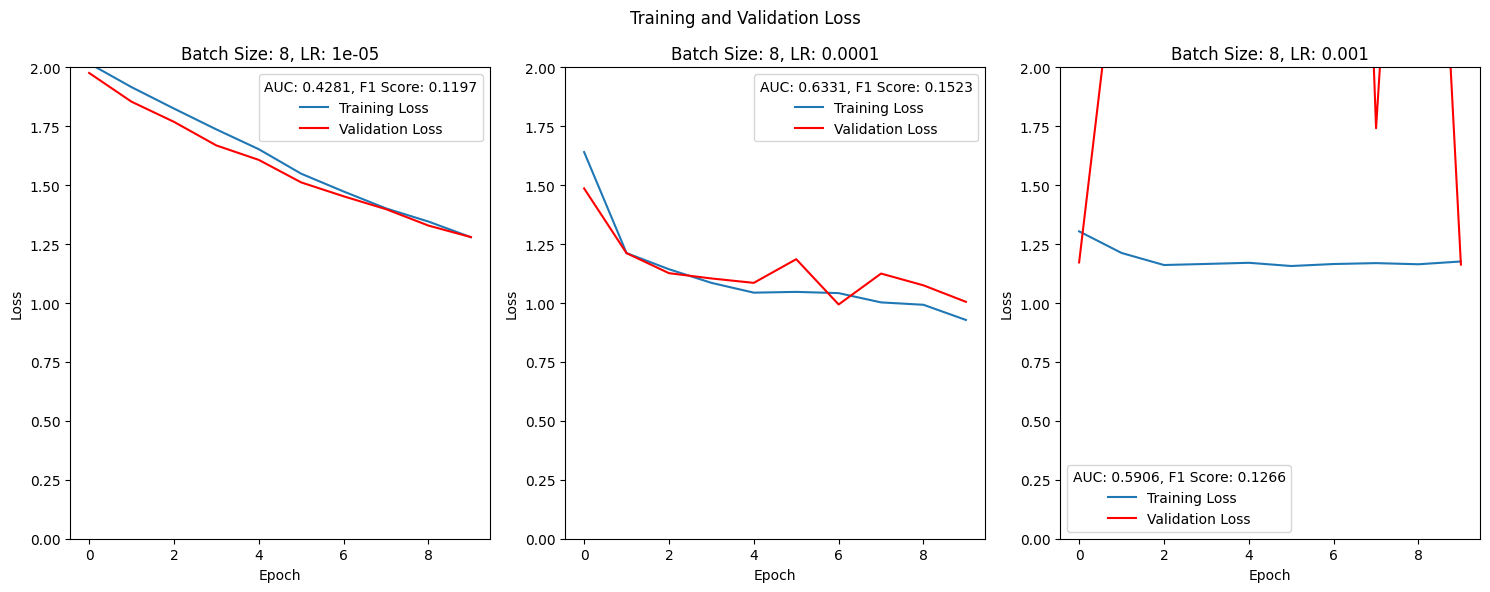

In [11]:
batch_sizes = [8]
learning_rates = [0.00001, 0.0001, 0.001] 

fig, axs = plt.subplots(len(batch_sizes), len(learning_rates), figsize=(15, 6))
plt.suptitle('Training and Validation Loss')

for i, batch_size in enumerate(batch_sizes):
    for j, learning_rate in enumerate(learning_rates):
        axs[j].plot(loss_dicts[i][j]['train'], label='Training Loss')
        axs[j].plot(loss_dicts[i][j]['validate'], label='Validation Loss', color='red')
        axs[j].set_title(f'Batch Size: {batch_size}, LR: {learning_rate}')
        axs[j].set_xlabel('Epoch')
        axs[j].set_ylabel('Loss')
        axs[j].set_ylim(0,2)
        axs[j].legend(title=f'AUC: {val_auc[i][j]:.4f}, F1 Score: {val_f1[i][j]:.4f}')

plt.tight_layout()
plt.savefig('hyperparameter_tuning_loss_pattern_efficientnetv2.png')
plt.show()

### Hyperparameter Tuned Pattern Classification Model

In [12]:
bs = 8
efficientnetv2_dataset = {'train': FashionDataset(full_train_data,'/vast/amr10211/cv_data/masked_images', 'pattern'), 
                  'validate': FashionDataset(full_val_data,'/vast/amr10211/cv_data/masked_images', 'pattern'), 
                  'test': FashionDataset(full_test_data, '/vast/amr10211/cv_data/masked_images', 'pattern')}

efficientnetv2_dataloader = {x: DataLoader(efficientnetv2_dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate', 'test']}

In [13]:
efficientnetv2_model_pattern = EfficientNetV2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnetv2_model_pattern.parameters(), lr=0.0001)

efficientnetv2_model_pattern, efficientnetv2_f1_dict, efficientnetv2_loss_dict = train_model(efficientnetv2_model_pattern, 
                                                                     efficientnetv2_dataloader, 
                                                                     optimizer, 
                                                                     loss_fn=criterion, 
                                                                     num_epochs=10, 
                                                                     verbose=True)

Epoch: 0/9
----------
Phase:train, epoch loss: 1.0426 Acc: 0.6838 F1 0.1496
Phase:validate, epoch loss: 0.9765 Acc: 0.7235 F1 0.1700
Epoch: 1/9
----------
Phase:train, epoch loss: 0.9394 Acc: 0.7159 F1 0.1891
Phase:validate, epoch loss: 0.8714 Acc: 0.7445 F1 0.2763
Epoch: 2/9
----------
Phase:train, epoch loss: 0.8759 Acc: 0.7374 F1 0.2630
Phase:validate, epoch loss: 0.8224 Acc: 0.7613 F1 0.2923
Epoch: 3/9
----------
Phase:train, epoch loss: 0.8344 Acc: 0.7525 F1 0.2895
Phase:validate, epoch loss: 0.7761 Acc: 0.7688 F1 0.3133
Epoch: 4/9
----------
Phase:train, epoch loss: 0.7950 Acc: 0.7620 F1 0.3094
Phase:validate, epoch loss: 0.7678 Acc: 0.7610 F1 0.3472
Epoch: 5/9
----------
Phase:train, epoch loss: 0.7682 Acc: 0.7704 F1 0.3263
Phase:validate, epoch loss: 0.7362 Acc: 0.7774 F1 0.3396
Epoch: 6/9
----------
Phase:train, epoch loss: 0.7425 Acc: 0.7789 F1 0.3434
Phase:validate, epoch loss: 0.7111 Acc: 0.7808 F1 0.3577
Epoch: 7/9
----------
Phase:train, epoch loss: 0.7100 Acc: 0.7858 F1 

In [14]:
torch.save(efficientnetv2_model_pattern, 'pattern_classification_model_efficientnetv2.pth')

In [15]:
with open('pattern_classification_model_loss_dict_efficientnetv2.pkl', 'wb') as f:
    pickle.dump(efficientnetv2_loss_dict, f)

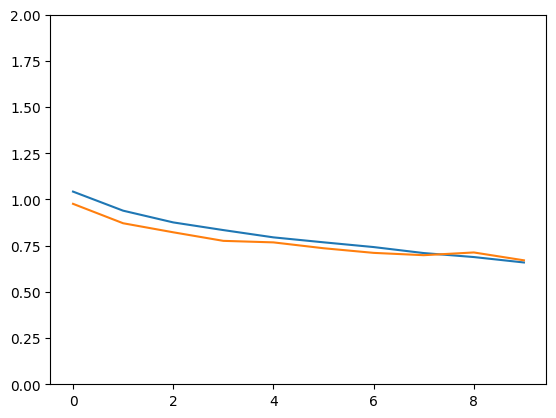

In [16]:
plt.plot(np.arange(0,10), efficientnetv2_loss_dict['train'])
plt.plot(np.arange(0,10), efficientnetv2_loss_dict['validate'])
plt.ylim(0,2);

In [17]:
correct = 0
total = 0
efficientnetv2_model_pattern.eval()
for data in efficientnetv2_dataloader['test']:
    optimizer.zero_grad()            
    image = data['x'].to(device)
    label = data['y'].to(device)
    output = efficientnetv2_model_pattern(image)
    pred = torch.argmax(output, axis=1)
    total += label.size(0)
    correct += (pred == label).sum()

test_acc = float(100 * correct / total)
print(test_acc)

78.90259552001953


In [18]:
efficientnetv2_model_pattern.eval()
y_true = []
y_pred = []

for data in efficientnetv2_dataloader['test']:
    optimizer.zero_grad()            
    image = data['x'].to(device)
    label = data['y'].to(device)
    output = efficientnetv2_model_pattern(image)
    pred = torch.argmax(output, axis=1)
    y_true.extend(label.cpu().numpy())
    y_pred.extend(pred.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Macro F1 score
macro_f1 = f1_score(y_true, y_pred, average='macro')

# One-vs-all AUC
# Binarize the labels
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
n_classes = y_true_bin.shape[1]

# Calculate one-vs-all AUC for each class
auc_scores = []
for i in range(n_classes):
    auc = roc_auc_score(y_true_bin[:, i], y_pred == i)
    auc_scores.append(auc)

# Average AUC scores across all classes
one_vs_all_auc = np.mean(auc_scores)

print("Macro F1 score:", macro_f1)
print("One-vs-all AUC:", one_vs_all_auc)


Macro F1 score: 0.39883603326707817
One-vs-all AUC: 0.66197519313874


### 25 Epochs Tuned Pattern Classification Model

In [9]:
bs = 8

efficientnetv2_dataset = {'train': FashionDataset(full_train_data,'/vast/amr10211/cv_data/masked_images', 'pattern'), 
                  'validate': FashionDataset(full_val_data,'/vast/amr10211/cv_data/masked_images', 'pattern'), 
                  'test': FashionDataset(full_test_data, '/vast/amr10211/cv_data/masked_images', 'pattern')}

efficientnetv2_dataloader = {x: DataLoader(efficientnetv2_dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate', 'test']}

In [10]:
efficientnetv2_model_pattern = torch.load('pattern_classification_model_efficientnetv2.pth').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnetv2_model_pattern.parameters(), lr=0.0001)

efficientnetv2_model_pattern, efficientnetv2_f1_dict, efficientnetv2_loss_dict = train_model(efficientnetv2_model_pattern, 
                                                                     efficientnetv2_dataloader, 
                                                                     optimizer, 
                                                                     loss_fn=criterion, 
                                                                     num_epochs=15, 
                                                                     verbose=True)

Epoch: 0/14
----------
Phase:train, epoch loss: 0.6217 Acc: 0.8122 F1 0.3995
Phase:validate, epoch loss: 0.6757 Acc: 0.7864 F1 0.3772
Epoch: 1/14
----------
Phase:train, epoch loss: 0.5861 Acc: 0.8223 F1 0.4214
Phase:validate, epoch loss: 0.6824 Acc: 0.7917 F1 0.4394
Epoch: 2/14
----------
Phase:train, epoch loss: 0.5407 Acc: 0.8320 F1 0.4480
Phase:validate, epoch loss: 0.7606 Acc: 0.7662 F1 0.3874
Epoch: 3/14
----------
Phase:train, epoch loss: 0.4952 Acc: 0.8444 F1 0.4821
Phase:validate, epoch loss: 0.7568 Acc: 0.7786 F1 0.4079
Epoch: 4/14
----------
Phase:train, epoch loss: 0.4628 Acc: 0.8538 F1 0.5186
Phase:validate, epoch loss: 0.8742 Acc: 0.7666 F1 0.4202
Epoch: 5/14
----------
Phase:train, epoch loss: 0.4148 Acc: 0.8683 F1 0.5631
Phase:validate, epoch loss: 0.8273 Acc: 0.7643 F1 0.4286
Epoch: 6/14
----------
Phase:train, epoch loss: 0.3761 Acc: 0.8769 F1 0.6002
Phase:validate, epoch loss: 0.8340 Acc: 0.7681 F1 0.4391
Epoch: 7/14
----------
Phase:train, epoch loss: 0.3478 Acc: 0.

In [11]:
torch.save(efficientnetv2_model_pattern, 'pattern_classification_model_25_epochs_efficientnetv2.pth')

In [7]:
efficientnetv2_model_pattern = torch.load('pattern_classification_model_25_epochs_efficientnetv2.pth')
optimizer = optim.Adam(efficientnetv2_model_pattern.parameters(), lr=0.0001)


In [20]:
correct = 0
total = 0
efficientnetv2_model_pattern.eval()
for data in efficientnetv2_dataloader['test']:
    optimizer.zero_grad()            
    image = data['x'].to(device)
    label = data['y'].to(device)
    output = efficientnetv2_model_pattern(image)
    pred = torch.argmax(output, axis=1)
    total += label.size(0)
    correct += (pred == label).sum()

test_acc = float(100 * correct / total)
print(test_acc)

78.09442901611328


In [21]:
efficientnetv2_model_pattern.eval()
y_true = []
y_pred = []
probs = []

for data in efficientnetv2_dataloader['test']:
    optimizer.zero_grad()            
    image = data['x'].to(device)
    label = data['y'].to(device)
    output = efficientnetv2_model_pattern(image)
    softmax = nn.Softmax(dim=1)
    prob = softmax(output)
    pred = torch.argmax(output, axis=1)
    y_true.extend(label.cpu().numpy())
    y_pred.extend(pred.cpu().numpy())
    probs.extend(prob.detach().cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
probs = np.array(probs)

# Macro F1 score
macro_f1 = f1_score(y_true, y_pred, average='macro')

# One-vs-all AUC
# Binarize the labels
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
n_classes = y_true_bin.shape[1]

auc_scores = []
for i in range(n_classes):
    auc = roc_auc_score(y_true_bin[:, i], probs[:, i])
    auc_scores.append(auc)


# Average AUC scores across all classes
one_vs_all_auc = np.mean(auc_scores)

print("Macro F1 score:", macro_f1)
print("One-vs-all AUC:", one_vs_all_auc)


Macro F1 score: 0.3982406326715239
One-vs-all AUC: 0.8926867312516211


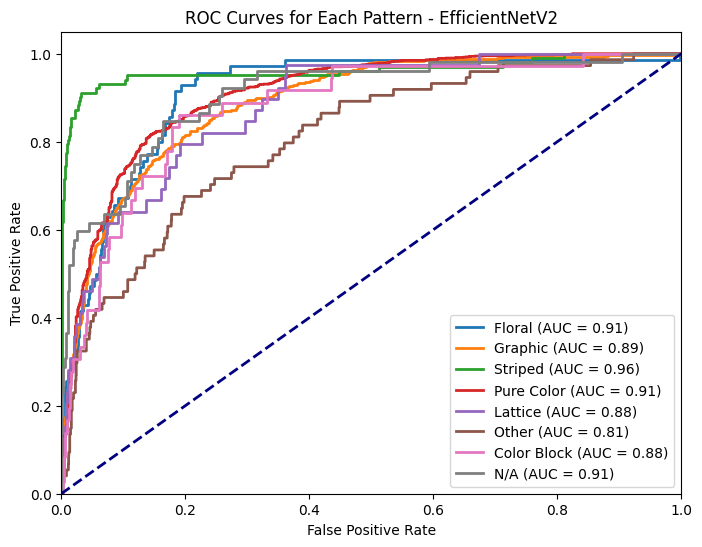

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define label mapping
label_mapping = {
    0: "Floral",
    1: "Graphic",
    2: "Striped",
    3: "Pure Color",
    4: "Lattice",
    5: "Other",
    6: "Color Block",
    7: "N/A"
}

# Plot class-level ROC curves
plt.figure(figsize=(8, 6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label_mapping[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Pattern - EfficientNetV2')
plt.legend(loc="lower right")
plt.show()